In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score


Columns in the dataset: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Dataset Description:
                 Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V

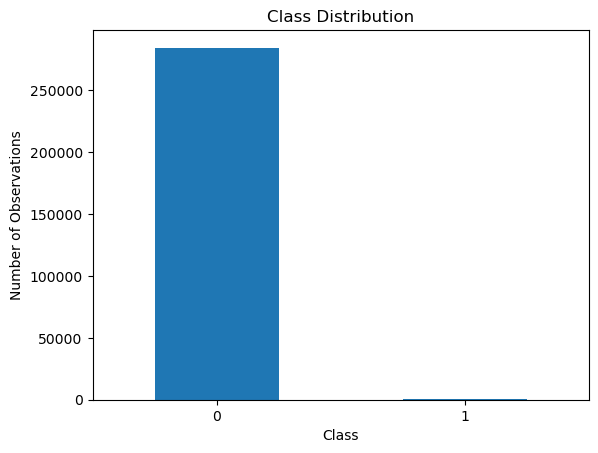

In [14]:
# Load the dataset
dataset = pd.read_csv("creditcard.csv")

# Display column names and dataset description
print("Columns in the dataset:", list(dataset.columns))
print("Dataset Description:\n", dataset.describe())

# Check for null values
print("Any null values:", dataset.isnull().values.any())

# Display label distribution
print("Unique labels:", dataset['Class'].unique())
print("Label values breakdown:\n", pd.value_counts(dataset['Class'], sort=True))

# Visualize class distribution
count_classes = pd.value_counts(dataset['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.xticks(range(len(dataset['Class'].unique())), dataset.Class.unique())
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Observations")
plt.show()


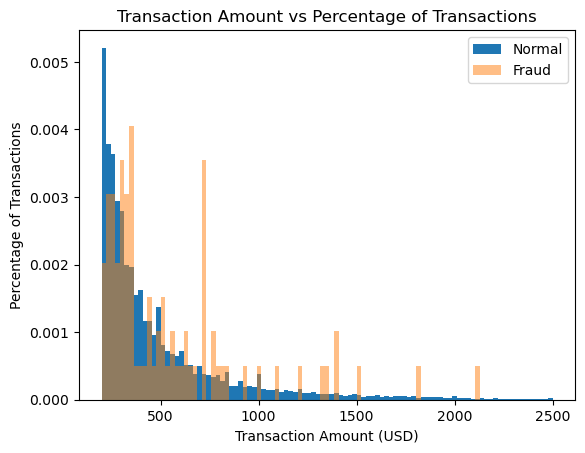

In [15]:
normal_dataset = dataset[dataset.Class == 0]
fraud_dataset = dataset[dataset.Class == 1]

bins = np.linspace(200, 2500, 100)
plt.hist(normal_dataset.Amount, bins=bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_dataset.Amount, bins=bins, alpha=0.5, density=True, label='Fraud')
plt.legend(loc='upper right')

plt.title("Transaction Amount vs Percentage of Transactions")
plt.xlabel("Transaction Amount (USD)")
plt.ylabel("Percentage of Transactions")
plt.show()


In [16]:
scaler = StandardScaler()
dataset['Time'] = scaler.fit_transform(dataset['Time'].values.reshape(-1, 1))
dataset['Amount'] = scaler.fit_transform(dataset['Amount'].values.reshape(-1, 1))

# Split the dataset into training and testing sets
train_x, test_x = train_test_split(dataset, test_size=0.3, random_state=2021)
train_x = train_x[train_x.Class == 0]  # Use only normal transactions for training
train_x = train_x.drop(['Class'], axis=1)

test_y = test_x['Class']  # Save the class column for evaluation
test_x = test_x.drop(['Class'], axis=1)

train_x = train_x.values
test_x = test_x.values


In [17]:
# Autoencoder parameters
input_dim = train_x.shape[1]
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2)
hidden_dim_2 = 4
learning_rate = 1e-7

# Define the model architecture
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",
                                activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)

autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_6 (Dense)             (None, 14)                434       
                                                                 
 dense_7 (Dense)             (None, 7)                 105       
                                                                 
 dense_8 (Dense)             (None, 4)                 32        
                                                                 
 dense_9 (Dense)             (None, 7)                 35        
                                                                 
 dense_10 (Dense)            (None, 14)                112       
                                                                 
 dense_11 (Dense)            (None, 30)                450 

In [18]:
# Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5", monitor='val_loss', verbose=1,
                                                save_best_only=True, mode='min')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, 
                                              restore_best_weights=True,mode='min' )

# Compile the model
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')

# Train the model
history = autoencoder.fit(train_x, train_x, epochs=50, batch_size=64, shuffle=True,
                          validation_data=(test_x, test_x), verbose=1, callbacks=[checkpoint, early_stop])


Epoch 1/50
3110/3110 [==============================] - ETA: 0s - loss: 0.7977 - accuracy: 0.3476
Epoch 1: val_loss improved from inf to 0.76197, saving model to autoencoder_fraud.h5


C:\Users\adity\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3110/3110 [==============================] - 85s 22ms/step - loss: 0.7977 - accuracy: 0.3476 - val_loss: 0.7620 - val_accuracy: 0.4125
Epoch 2/50
3106/3110 [============================>.] - ETA: 0s - loss: 0.7088 - accuracy: 0.4360
Epoch 2: val_loss improved from 0.76197 to 0.72600, saving model to autoencoder_fraud.h5
3110/3110 [==============================] - 68s 22ms/step - loss: 0.7086 - accuracy: 0.4360 - val_loss: 0.7260 - val_accuracy: 0.4558
Epoch 3/50
3110/3110 [==============================] - ETA: 0s - loss: 0.6863 - accuracy: 0.4555
Epoch 3: val_loss improved from 0.72600 to 0.71264, saving model to autoencoder_fraud.h5
3110/3110 [==============================] - 59s 19ms/step - loss: 0.6863 - accuracy: 0.4555 - val_loss: 0.7126 - val_accuracy: 0.4590
Epoch 4/50
3110/3110 [==============================] - ETA: 0s - loss: 0.6744 - accuracy: 0.4532
Epoch 4: val_loss improved from 0.71264 to 0.70034, saving model to autoencoder_fraud.h5
3110/3110 [=======================

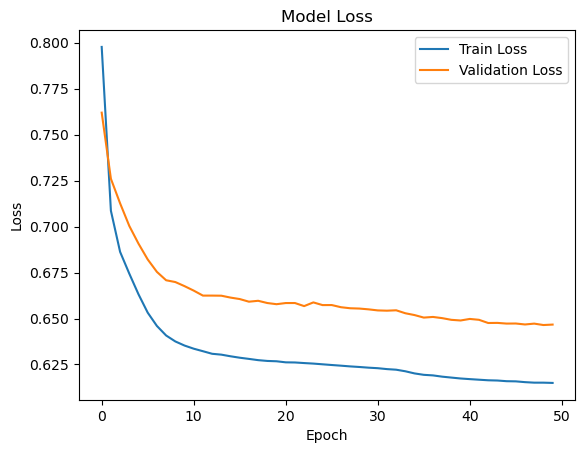

In [19]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [20]:
# Predict on the test set
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)

# Create a DataFrame to analyze reconstruction errors
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': test_y})
error_df.describe()


2671/2671 [==============================] - 5s 2ms/step


,Reconstruction_error,True_class
count,85443.000000,85443.000000
mean,0.646701,0.001662
std,3.484875,0.040733
min,0.025939,0.000000
25%,0.165813,0.000000
50%,0.284743,0.000000
75%,0.486760,0.000000
max,292.816879,1.000000


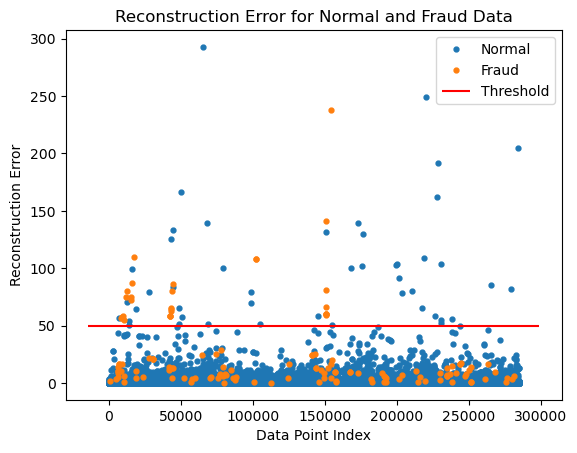

In [21]:
threshold_fixed = 50
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label="Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction Error for Normal and Fraud Data")
plt.xlabel("Data Point Index")
plt.ylabel("Reconstruction Error")
plt.show()


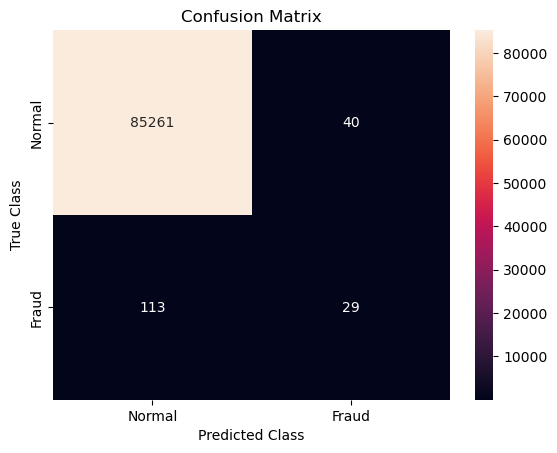

Accuracy:  0.9982093325374811
Recall:  0.20422535211267606
Precision:  0.42028985507246375


In [22]:
# Detect anomalies based on the threshold
threshold_fixed = 52
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['Predicted_class'] = pred_y

# Compute and display the confusion matrix
conf_matrix = confusion_matrix(error_df['True_class'], error_df['Predicted_class'])
sns.heatmap(conf_matrix, xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"], annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Print accuracy, precision, and recall
print("Accuracy: ", accuracy_score(error_df['True_class'], error_df['Predicted_class']))
print("Recall: ", recall_score(error_df['True_class'], error_df['Predicted_class']))
print("Precision: ", precision_score(error_df['True_class'], error_df['Predicted_class']))
